In [1]:
!pip install pmdarima

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

In [2]:
from math import sqrt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [3]:
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('../../data/sensor1.csv')

In [5]:
df = df.dropna()

In [6]:
units_dict = {}

for col in df.columns[1:]:
    values = []
    units = set()
    for val in df[col]:
        value, unit = val.split()
        values.append(value)
        units.add(unit)
    new_col_name = f"{col} ({units.pop()})"
    df.rename(columns={col: new_col_name}, inplace=True)
    df[new_col_name] = pd.to_numeric(values)
    units_dict[col] = units

In [7]:
df['Time'] = pd.to_datetime(df['Time'])

In [8]:
df.index = df['Time']
df.drop(columns=['Time'], inplace=True)

In [9]:
df = df.sort_index()

In [10]:
co2 = df["CO2 (ppm)"]

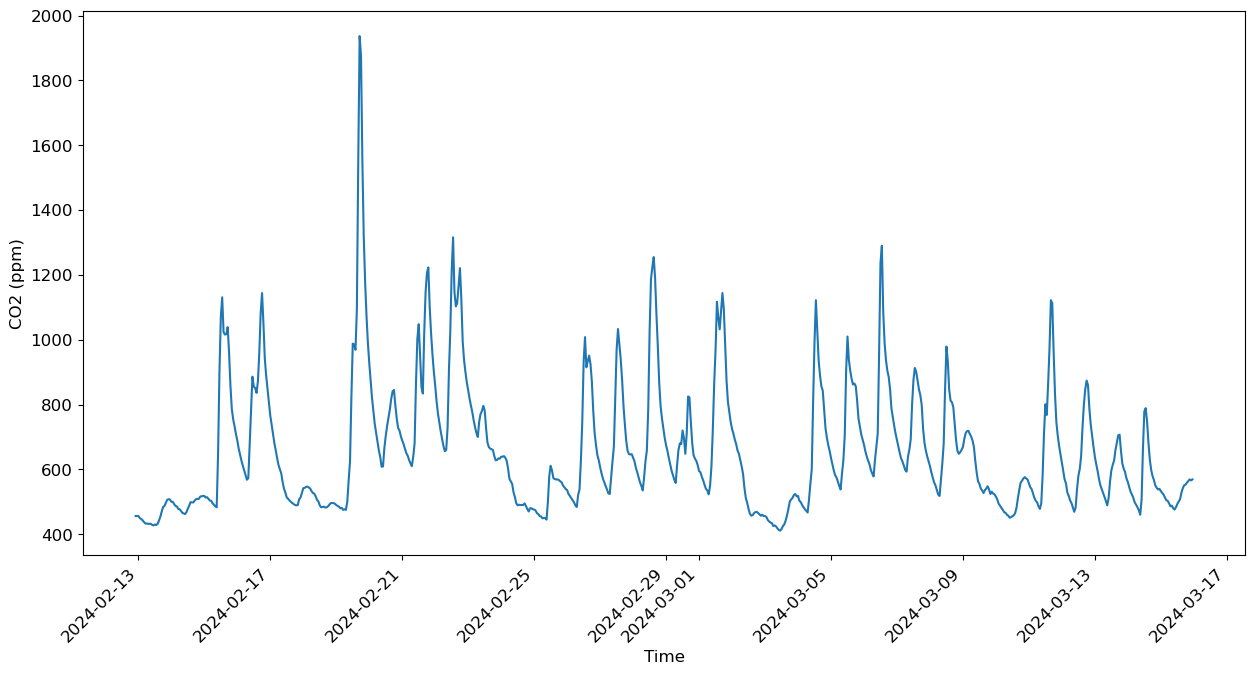

In [11]:
co2.plot(y='CO2 (ppm)', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('CO2 (ppm)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Create training and testing datasets

In [12]:
train_size = int(0.8 * len(df))

In [13]:
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [14]:
train_start_dt = train_df.index[0]
test_start_dt = test_df.index[0]

In [15]:
train_start_dt, test_start_dt

(Timestamp('2024-02-12 22:00:00'), Timestamp('2024-03-09 14:00:00'))

In [16]:
df

CO2 (ppm)  Humidity (%H)  PM10 (μg/m³)  PM2.5 (μg/m³)  \
Time                                                                         
2024-02-12 22:00:00        456           79.0          5.60           5.60   
2024-02-12 23:00:00        456           79.0          5.25           5.13   
2024-02-13 00:00:00        456           79.0          6.00           5.89   
2024-02-13 01:00:00        450           79.0          6.44           6.33   
2024-02-13 02:00:00        447           79.0          6.25           5.88   
...                        ...            ...           ...            ...   
2024-03-15 19:00:00        559           79.2         18.30          18.00   
2024-03-15 20:00:00        564           79.3         18.80          17.70   
2024-03-15 21:00:00        569           78.8         17.50          16.20   
2024-03-15 22:00:00        566           78.5         17.80          17.50   
2024-03-15 23:00:00        569           78.5         17.00          17.00   

                     Temperature (°C)  TVOC (ppm)  
Time                                               
2024-02-12 22:00:00              24.0       0.642  
2024-02-12 23:00:00              24.1       0.711  
2024-02-13 00:00:00              24.2       0.744  
2024-02-13 01:00:00              24.2       0.759  
2024-02-13 02:00:00              24.3       0.775  
...                               ...         ...  
2024-03-15 19:00:00              23.0       0.590  
2024-03-15 20:00:00              23.3       0.597  
2024-03-15 21:00:00              23.6       0.613  
2024-03-15 22:00:00              23.8       0.662  
2024-03-15 23:00:00              23.9       0.660  

[768 rows x 6 columns]

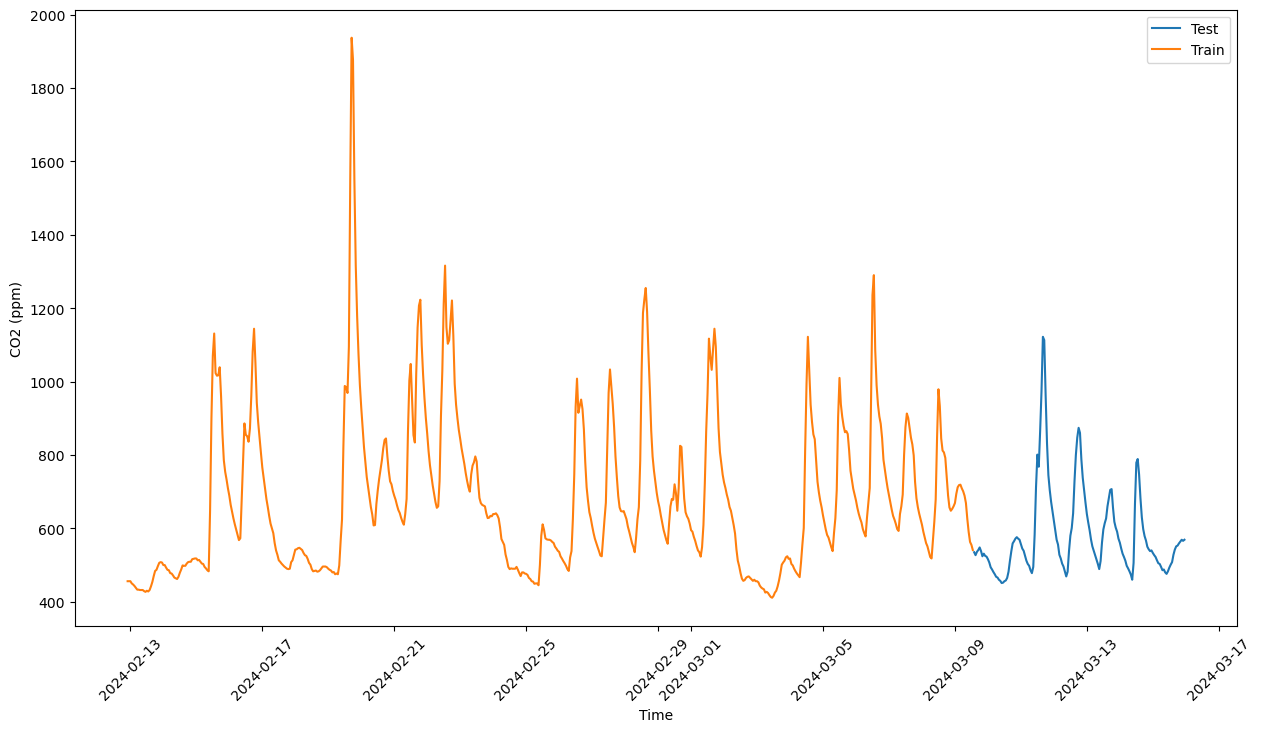

In [17]:
test_co2 = df[df.index >= test_start_dt]["CO2 (ppm)"]
train_co2 = df[(df.index < test_start_dt) & (df.index >= train_start_dt)]["CO2 (ppm)"]

plt.figure(figsize=(15, 8))
plt.plot(test_co2.index, test_co2.values, label='Test')

plt.plot(train_co2.index, train_co2.values, label='Train')

plt.xlabel('Time')
plt.ylabel('CO2 (ppm)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Data preparation

In [18]:
train_co2_reshaped = train_co2.values.reshape(-1, 1)
test_co2_reshaped = test_co2.values.reshape(-1, 1)

In [19]:
print("Training data shape: ", train_co2_reshaped.shape)
print("Test data shape: ", test_co2_reshaped.shape)

Training data shape:  (614, 1)
Test data shape:  (154, 1)


In [20]:
scaler = MinMaxScaler()
train_co2_scaled = scaler.fit_transform(train_co2_reshaped)
train_co2_scaled = pd.DataFrame(train_co2_scaled.flatten(), index=train_co2.index, columns=["CO2 (ppm)"])
train_co2_scaled.head(10)

CO2 (ppm)
Time                          
2024-02-12 22:00:00   0.029489
2024-02-12 23:00:00   0.029489
2024-02-13 00:00:00   0.029489
2024-02-13 01:00:00   0.025557
2024-02-13 02:00:00   0.023591
2024-02-13 03:00:00   0.020970
2024-02-13 04:00:00   0.017693
2024-02-13 05:00:00   0.014417
2024-02-13 06:00:00   0.014417
2024-02-13 07:00:00   0.013761

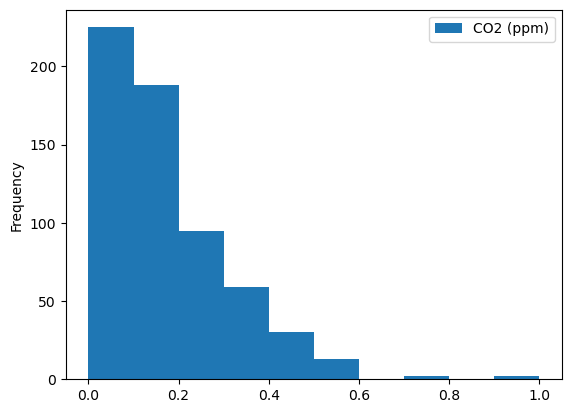

In [21]:
train_co2_scaled.plot.hist(bins=10)
plt.show()

In [22]:
test_co2_scaled = scaler.fit_transform(test_co2_reshaped)
test_co2_scaled = pd.DataFrame(test_co2_scaled.flatten(), index=test_co2.index, columns=["CO2 (ppm)"])
test_co2_scaled.head(10)

CO2 (ppm)
Time                          
2024-03-09 14:00:00   0.125186
2024-03-09 15:00:00   0.113264
2024-03-09 16:00:00   0.126677
2024-03-09 17:00:00   0.134128
2024-03-09 18:00:00   0.144560
2024-03-09 19:00:00   0.129657
2024-03-09 20:00:00   0.108793
2024-03-09 21:00:00   0.119225
2024-03-09 22:00:00   0.110283
2024-03-09 23:00:00   0.107303

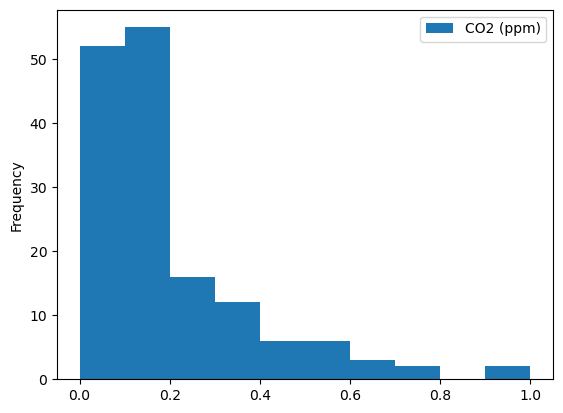

In [23]:
test_co2_scaled.plot.hist(bins=10)
plt.show()

In [24]:
HORIZON_CO2 = 1

In [25]:
stepwise_fit_co2 = auto_arima(train_co2_scaled, trace=True, suppress_warnings=True)
stepwise_fit_co2.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2580.335, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-670.745, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2186.509, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1423.652, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-89.640, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2575.794, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-2576.310, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-2579.000, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-2578.094, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2511.643, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-2582.570, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-2248.077, Time=0.10 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-2581.437, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-1940.706, Time=0.07 sec
 ARIMA(0,0,4)(0,0,0)[0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  614
Model:               SARIMAX(1, 0, 3)   Log Likelihood                1297.285
Date:                Fri, 15 Mar 2024   AIC                          -2582.570
Time:                        23:20:10   BIC                          -2556.050
Sample:                             0   HQIC                         -2572.257
                                - 614                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0237      0.007      3.300      0.001       0.010       0.038
ar.L1          0.8631      0.020     43.786      0.000       0.824       0.902
ma.L1          0.9457      0.021     46.058      0.000       0.905       0.986
ma.L2          0.4940      0.037     13.284      0.000       0.421       0.567
ma.L3          0.1405      0.032      4.327      0.000       0.077       0.204
sigma2         0.0008   1.96e-05     43.421      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7421.52
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             1.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
order_co2 = (1,0,3)

In [27]:
model_temp =  ARIMA(endog=train_co2_scaled, order=order_co2)
result_temp = model_temp.fit()

print(result_temp.summary())

                               SARIMAX Results                                
Dep. Variable:              CO2 (ppm)   No. Observations:                  614
Model:                 ARIMA(1, 0, 3)   Log Likelihood                1297.285
Date:                Fri, 15 Mar 2024   AIC                          -2582.569
Time:                        23:20:21   BIC                          -2556.049
Sample:                             0   HQIC                         -2572.256
                                - 614                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1729      0.034      5.071      0.000       0.106       0.240
ar.L1          0.8629      0.020     43.763      0.000       0.824       0.902
ma.L1          0.9460      0.021     46.082      0.0

Walk-forward validation

Create a test data point for each HORIZON.<br>
Shift the data horizontally according to its horizon point.

In [28]:
test_co2_shifted = test_co2_scaled.copy()

for t in range(1, HORIZON_CO2):
    test_co2_shifted["CO2 (ppm)+" + str(t)] = test_co2_shifted["CO2 (ppm)"].shift(-t, freq='H')
    
test_co2_shifted = test_co2_shifted.dropna(how='any')
test_co2_shifted.head()

CO2 (ppm)
Time                          
2024-03-09 14:00:00   0.125186
2024-03-09 15:00:00   0.113264
2024-03-09 16:00:00   0.126677
2024-03-09 17:00:00   0.134128
2024-03-09 18:00:00   0.144560

Make predictions on the test data using a sliding window approach in a loop the size of the test data length.

In [29]:
stepwise_fit_co2_test = auto_arima(test_co2_scaled, trace=True, suppress_warnings=True)
stepwise_fit_co2_test.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-564.425, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-82.871, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-432.394, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-270.644, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=33.526, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-560.019, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-559.016, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-558.029, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-563.719, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-523.916, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-565.763, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-487.903, Time=0.03 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-563.828, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-397.801, Time=0.03 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  154
Model:               SARIMAX(1, 0, 3)   Log Likelihood                 288.881
Date:                Fri, 15 Mar 2024   AIC                           -565.763
Time:                        23:20:26   BIC                           -547.541
Sample:                    03-09-2024   HQIC                          -558.361
                         - 03-15-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0369      0.023      1.587      0.112      -0.009       0.082
ar.L1          0.8106      0.044     18.493      0.000       0.725       0.896
ma.L1          1.0996      0.054     20.253      0.000       0.993       1.206
ma.L2          0.8044      0.057     14.178      0.000       0.693       0.916
ma.L3          0.2604      0.048      5.475      0.000       0.167       0.354
sigma2         0.0013   8.21e-05     16.274      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2284.32
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             3.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
test_co2_shifted

CO2 (ppm)
Time                          
2024-03-09 14:00:00   0.125186
2024-03-09 15:00:00   0.113264
2024-03-09 16:00:00   0.126677
2024-03-09 17:00:00   0.134128
2024-03-09 18:00:00   0.144560
...                        ...
2024-03-15 19:00:00   0.160954
2024-03-15 20:00:00   0.168405
2024-03-15 21:00:00   0.175857
2024-03-15 22:00:00   0.171386
2024-03-15 23:00:00   0.175857

[154 rows x 1 columns]

In [31]:
%%time
training_window = 168

train_ts_co2 = train_co2_scaled["CO2 (ppm)"]
test_ts_co2 = test_co2_shifted

history_co2 = [x for x in train_ts_co2]
history_co2 = history_co2[(-training_window):]

predictions_co2 = list()

# order = (1,0,3)

for t in range(test_ts_co2.shape[0]):
    model_co2 = ARIMA(endog=history_co2, order=order_co2)
    model_fit_co2 = model_co2.fit()
    yhat = model_fit_co2.forecast(steps = HORIZON_CO2)
    predictions_co2.append(yhat)
    obs = list(test_ts_co2.iloc[t])
    # move the training window
    history_co2.append(obs[0])
    history_co2.pop(0)
    print(test_ts_co2.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2024-03-09 14:00:00
1 : predicted = [0.08174336] expected = [0.1251862891207154]
2024-03-09 15:00:00
2 : predicted = [0.16869823] expected = [0.11326378539493298]
2024-03-09 16:00:00
3 : predicted = [0.08378463] expected = [0.12667660208643816]
2024-03-09 17:00:00
4 : predicted = [0.15026517] expected = [0.13412816691505214]
2024-03-09 18:00:00
5 : predicted = [0.13858906] expected = [0.14456035767511177]
2024-03-09 19:00:00
6 : predicted = [0.14612095] expected = [0.12965722801788382]
2024-03-09 20:00:00
7 : predicted = [0.12107177] expected = [0.10879284649776455]
2024-03-09 21:00:00
8 : predicted = [0.09857614] expected = [0.11922503725782418]
2024-03-09 22:00:00
9 : predicted = [0.14038862] expected = [0.11028315946348732]
2024-03-09 23:00:00
10 : predicted = [0.09792565] expected = [0.10730253353204178]
2024-03-10 00:00:00
11 : predicted = [0.11282897] expected = [0.09687034277198214]
2024-03-10 01:00:00
12 : predicted = [0.09541844] expected = [0.08345752608047696]
2024-03-10 02:

Compare the prediction against the actual CO2.

In [32]:
eval_df_co2 = pd.DataFrame(predictions_co2, columns=['t+'+str(t) for t in range(1, HORIZON_CO2+1)])
eval_df_co2['Time'] = test_co2_scaled.index[0:len(test_co2_scaled.index)-HORIZON_CO2+1]
eval_df_co2 = pd.melt(eval_df_co2, id_vars='Time', value_name='Prediction', var_name='H')
eval_df_co2['Actual'] = np.array(np.transpose(test_ts_co2)).ravel()
eval_df_co2[['Prediction', 'Actual']] = scaler.inverse_transform(eval_df_co2[['Prediction', 'Actual']])
eval_df_co2.head()

Time    H  Prediction  Actual
0 2024-03-09 14:00:00  t+1  505.849795   535.0
1 2024-03-09 15:00:00  t+1  564.196514   527.0
2 2024-03-09 16:00:00  t+1  507.219484   536.0
3 2024-03-09 17:00:00  t+1  551.827931   541.0
4 2024-03-09 18:00:00  t+1  543.993258   548.0

Check the model accuracy by testing its mean absolute percentage error (MAPE) over all the predictions.

In [33]:
if (HORIZON_CO2 > 1):
    eval_df_co2['APE'] = (eval_df_co2['Prediction'] - eval_df_co2['Actual']).abs()
    print(eval_df_co2.groupby('H')['APE'].mean())

In [34]:
# Mean absolute percentage error
def mape(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return (np.absolute(predictions - actuals) / actuals).mean()

In [35]:
print('Multi-step forecast MAPE: ', mape(eval_df_co2['Prediction'], eval_df_co2['Actual'])*100, '%')

Multi-step forecast MAPE:  2.431408477221718 %


In [36]:
rmse_co2 = sqrt(mean_squared_error(eval_df_co2['Prediction'], eval_df_co2['Actual']))
rmse_co2

27.907654107540743

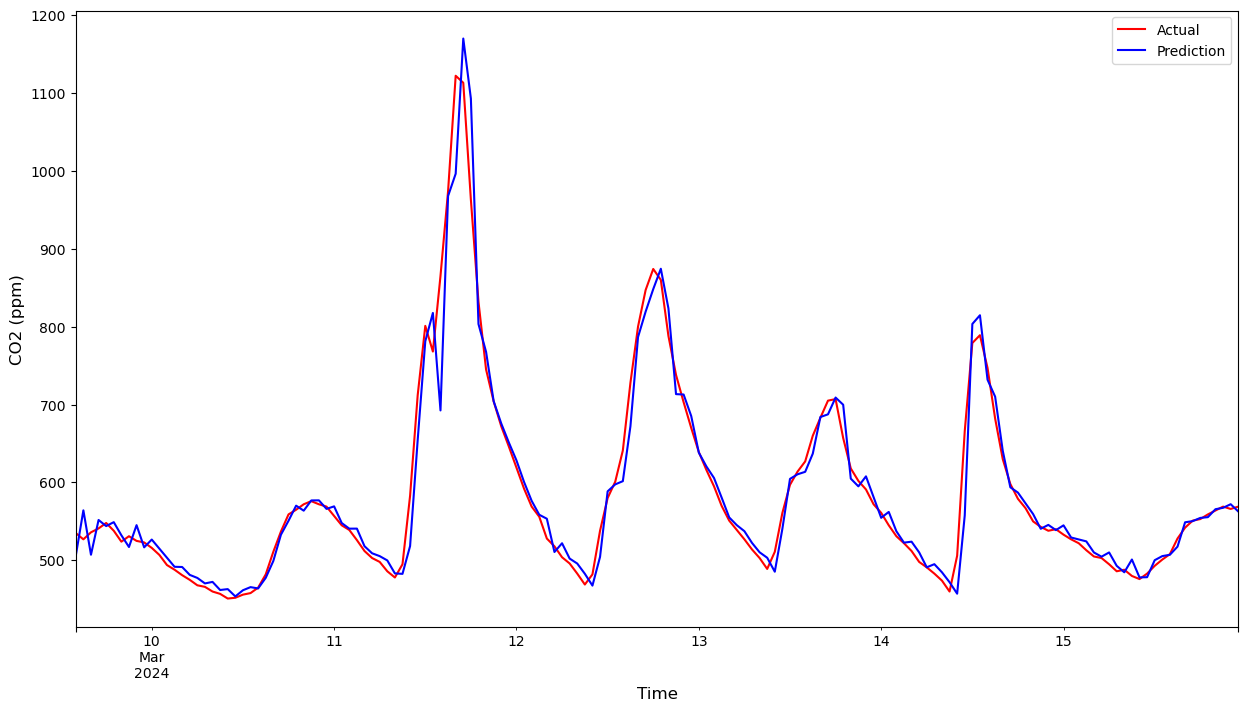

In [37]:
if HORIZON_CO2 == 1:
    eval_df_co2.plot(x='Time', y=['Actual', 'Prediction'], style=['r', 'b'], figsize=(15, 8))
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('CO2 (ppm)', fontsize=12)
    plt.legend(['Actual', 'Prediction'], loc='best')
    plt.show()
else:
    plot_df_co2 = eval_df_co2[(eval_df_co2.H == 't+1')][['Time', 'Actual']]
    for t in range(1, HORIZON_CO2 + 1):
        plot_df_co2['t+' + str(t)] = eval_df_co2[(eval_df_co2.H == 't+' + str(t))]['Prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.plot(plot_df_co2['Time'], plot_df_co2['Actual'], color='red', linewidth=4.0, label='Actual')
    for t in range(1, HORIZON_CO2 + 1):
        x = plot_df_co2['Time'][(t - 1):]
        y = plot_df_co2['t+' + str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4 * math.pow(.9, t), alpha=math.pow(0.8, t),
                label='Prediction t+' + str(t))

    ax.legend(loc='best')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('CO2', fontsize=12)
    plt.show()

In [38]:
next_hour = pd.date_range(start=df.index[-1], periods=2, freq='H')[-1]

In [39]:
pred_co2 = model_fit_co2.predict(start=len(df), end=len(df), typ="levels")[0]
pred_co2_nonscaled = round(scaler.inverse_transform(np.array(pred_co2).reshape(-1, 1))[0][0], 1)
print(f"{next_hour} {pred_co2_nonscaled}")

2024-03-16 00:00:00 579.4
